In [1]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *
class FeatureSet(Dataset):
    def __init__(self,X):
        self.len = len(X)
        self.X = cat([zeros(4,5000),X,zeros(4,5000)])

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx:idx+9].flatten()

In [2]:
model = Gandalf()
model.load_state_dict(torch.load(f=f'../models/gandalfs/gandalf_0/best_model.pt',map_location='cpu'))
model.to(DEVICE);

In [3]:
from mne.io import read_raw_edf
mapping = {
    "SPARC-10-M":"EEG 1", 
    "SPARC-11-M":"EEG 1",
    "SPARC-12-M":"EEG 1",
    "SPARC-13-M":"EEG 1",
    "SPARC-14-M":"EEG 1",
    "SPARC-15-M":"EEG 1",
    "SPARC-17-M":"EEG 2",
    "SPARC-18-M":"EEG 1",
    "SPARC-2-F":"EEG 1",
    "SPARC-4-F":"EEG 1",
    "SPARC-5-F":"Channel-2",
    "SPARC-8-F":"Channel-10",
    "SPARC-9-F ":"Channel-2",
    "SPARC-10-F":"Channel-50",
    "SPARC-11-F":"Channel-18",
    "SPARC-12-F":"Channel-42",
    "SPARC-13-F":"EEG 1",
    "SPARC-14-F":"EEG 1",
    "SPARC-15-F":"EEG 1",
    "SPARC-16-F":"EEG 2"
}

In [4]:
i = 1
filename = list(mapping.keys())[i]
raw = read_raw_edf(f'../data/ICV/edf/{filename}.edf',include=[mapping[filename]],verbose=False)
print(f'mapping: {mapping[filename]}')
for name in raw.ch_names:
    print(name)
eeg = raw.get_data()

mapping: EEG 1
EEG 1


In [5]:
eeg = eeg.reshape(-1,5000)
eeg = torch.from_numpy(eeg).float()
print(eeg.shape)
dataloader = DataLoader(dataset=FeatureSet(eeg),batch_size=32,shuffle=False)

torch.Size([76411, 5000])


In [6]:
raw.info['meas_date']

datetime.datetime(2021, 12, 6, 13, 56, 27, tzinfo=datetime.timezone.utc)

In [8]:
def score(dataloader,model,DEVICE=DEVICE):
    with torch.no_grad():
        y_pred = torch.Tensor()
        y_logits = torch.Tensor()
        for Xi in tqdm(dataloader):
            Xi = Xi.to(DEVICE)
            logits = model(Xi)
            y_logits = torch.cat([y_logits,torch.softmax(logits,dim=1).detach().cpu()])
            y_pred = torch.cat([y_pred,torch.softmax(logits,dim=1).argmax(axis=1).detach().cpu()])
    return y_pred,y_logits

In [9]:
y_pred,y_logits = score(dataloader,model)

  0%|          | 0/2388 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 2388/2388 [01:19<00:00, 30.19it/s]


In [13]:
torch.bincount(y_pred.long())

tensor([ 3739, 24084, 48588])

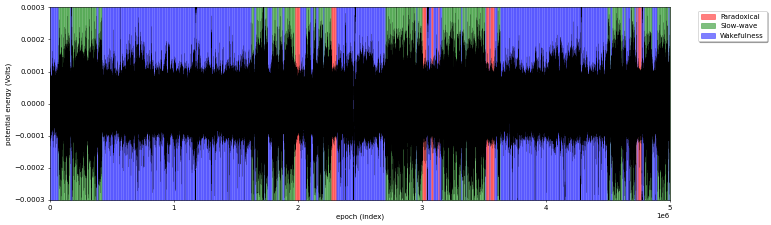

In [75]:
fig, ax = plt.subplots(figsize=(16,5),dpi=50)
import matplotlib.patches as patches

start_epoch = 20000
length = 1000
plt.plot(eeg[start_epoch:start_epoch+length].flatten(),'black',linewidth=.2);

colors = ['red','green','blue']
epochs = []
for i in range(length):
    stage = int(y_pred[start_epoch+i])
    ax.fill_between([i*5000, (i+1)*5000], y1=-.0003, y2=.0003, color=colors[stage], alpha=0.3)
    epochs.append(i*5000+2500)

# 4. Add a legend for the background colors using proxy artists
red_patch = patches.Patch(color='red', alpha=0.5, label='Paradoxical')
green_patch = patches.Patch(color='green', alpha=0.5, label='Slow-wave')
blue_patch = patches.Patch(color='blue', alpha=0.5, label='Wakefulness')
plt.ylim([-.0003,.0003])
plt.margins(0,0)
# ax.legend(handles=[red_patch, green_patch,blue_patch],loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(handles=[red_patch, green_patch,blue_patch],loc='upper left', bbox_to_anchor=(1.04, 1),
          fancybox=True, shadow=True, ncol=1)
plt.xlabel('epoch (index)')
plt.ylabel('potential energy (Volts)')
# plt.xticks(epochs,range(length));
plt.savefig('out.jpg')

In [21]:
path = f'../data/ICV/csv'
import os
for file in os.listdir(f'{path}'):
    df = pd.read_csv(f'{path}/{file}')
    print(df['0'].value_counts(normalize=True))

W    0.680866
P    0.318837
S    0.000297
Name: 0, dtype: float64
W    0.653440
S    0.292418
P    0.054142
Name: 0, dtype: float64
W    0.695437
S    0.284317
P    0.020246
Name: 0, dtype: float64
W    0.552963
S    0.405860
P    0.041176
Name: 0, dtype: float64
W    0.563348
S    0.363816
P    0.072836
Name: 0, dtype: float64
W    0.606361
P    0.392628
S    0.001011
Name: 0, dtype: float64
W    0.672933
S    0.296653
P    0.030413
Name: 0, dtype: float64
W    0.635877
S    0.315190
P    0.048933
Name: 0, dtype: float64
W    0.516522
S    0.441743
P    0.041735
Name: 0, dtype: float64
W    0.630949
S    0.313081
P    0.055970
Name: 0, dtype: float64
W    0.618223
S    0.352374
P    0.029404
Name: 0, dtype: float64
W    0.612345
S    0.362996
P    0.024659
Name: 0, dtype: float64
W    0.608589
S    0.343013
P    0.048398
Name: 0, dtype: float64
W    0.882639
P    0.117361
Name: 0, dtype: float64
W    0.579712
S    0.392772
P    0.027516
Name: 0, dtype: float64
W    0.620544
S    0.325